# Region Manifold Extraction

In [1]:
#
# This is a hidden cell in the rendered notebook.
# See Edit -> Edit Notebook Metadata -> Cell metadata
# i.e., "tags": [ "remove-cell" ]
#

from __future__ import annotations

import pyvista

import geovista.cache
import geovista.theme

# Tip: Change this to "trame" for an interactive backend.
pyvista.set_jupyter_backend("static")
# Silence the geovista pooch cache manager when downloading resources.
geovista.cache.pooch_mute()

## {fa}`comment-dots` Introduction

```{figure} ../_static/images/cubed-sphere.jpg
---
figclass: margin
alt: Cubed-Sphere
name: tutorial-cubed-sphere
---
Cubed-Sphere
```

In this tutorial we use **unstructured cubed-sphere** sample data from the {py:mod}`~geovista.pantry` to explore mesh regional extraction using a geodesic manifold. 

## {fa}`rocket` Let's Go!

The [Met Office](https://www.metoffice.gov.uk/) is migrating to a unstructured cubed-sphere quadrilateral-cell mesh, which is a gridded cube projected onto a sphere i.e., there are **6 panels** on the sphere, see {numref}`tutorial-cubed-sphere`.

Each cubed-sphere is defined by the number of *cells squared* within each panel. In this tutorial we'll use a **C48 cubed-sphere**, so there are ``48 * 48`` cells per panel, and ``6 * 48 * 48`` cells in a mesh overall.

First, let's import ``geovista`` and generate some **LFRic model** cubed-sphere sample data using the {py:func}`~geovista.pantry.meshes.lfric` and {py:func}`~geovista.pantry.meshes.lfric_sst` convenience functions:

```{seealso}
---
class: margin, dropdown, toggle-shown
---
For those interested in LFRic, please refer to [LFRic - a modelling system fit for future computers](https://www.metoffice.gov.uk/research/approach/modelling-systems/lfric).
```

In [2]:
import geovista as gv
from geovista.pantry.meshes import lfric, lfric_sst

As the {py:func}`~geovista.pantry.meshes.lfric` and {py:func}`~geovista.pantry.meshes.lfric_sst` functions both return a [](#pyvista.PolyData) we can simply use the [](#pyvista.DataSet.plot) method to render them:

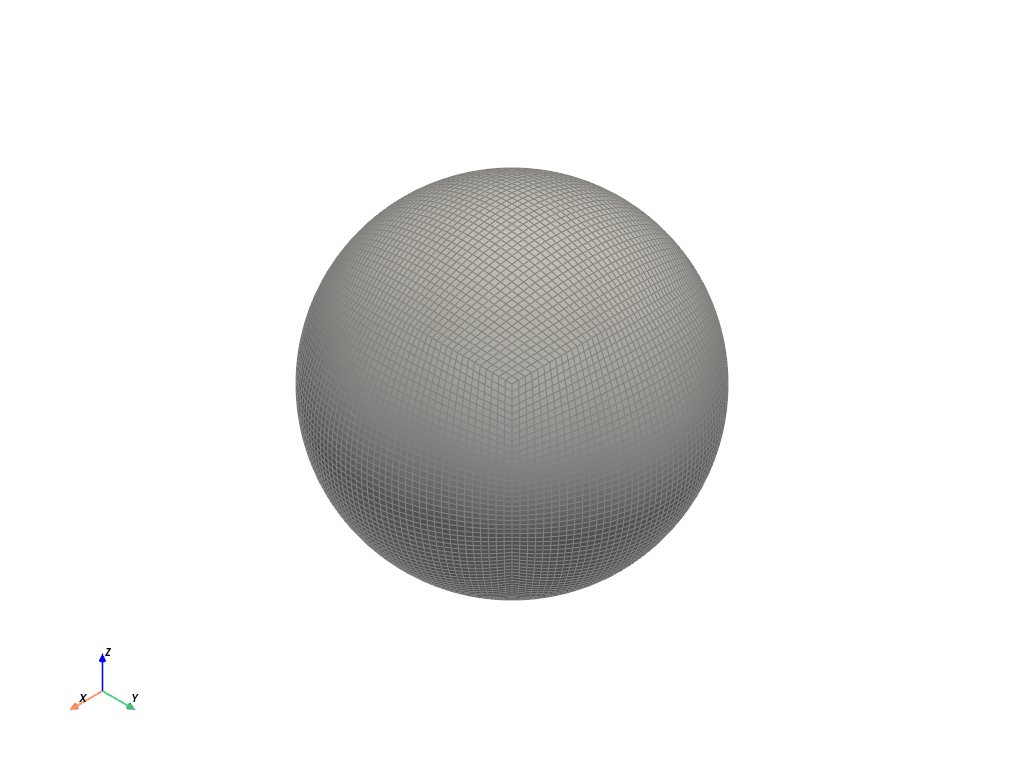

In [3]:
c48 = lfric(resolution="c48")
c48.plot(show_edges=True)

Now create the same C48 cubed-sphere resolution mesh, but this time with cells populated with *Sea Surface Temperature* (SST) data. Note that the land masses are masked, as this is an oceanographic dataset. Masked cells within the mesh will have ``nan`` values:

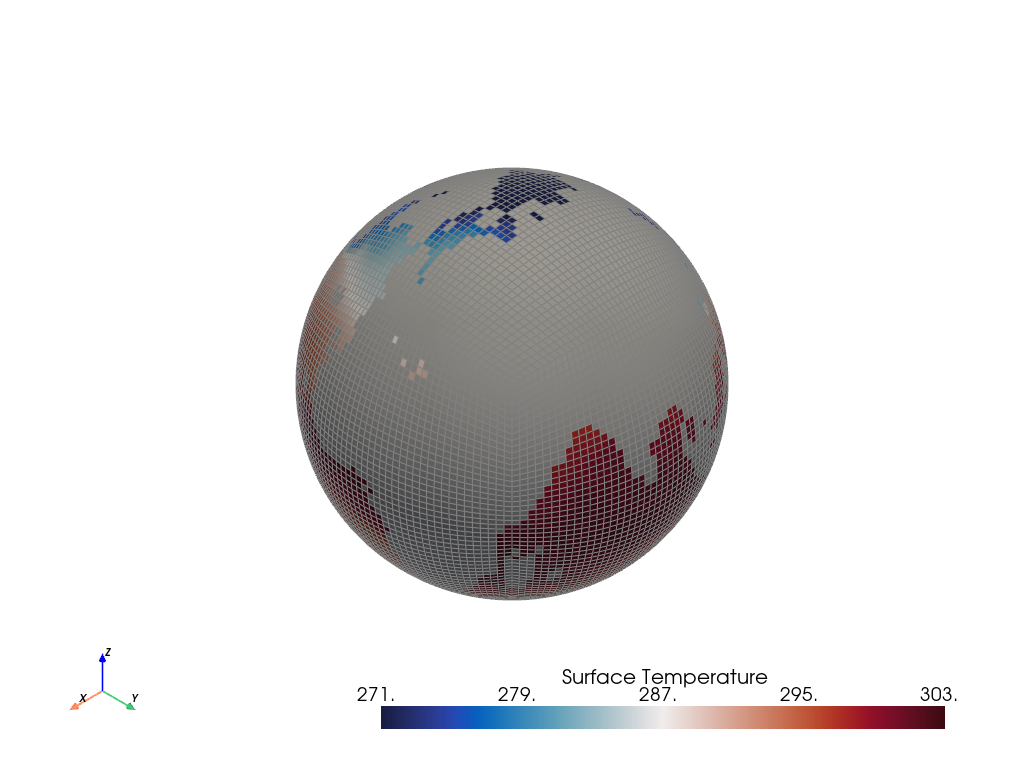

In [4]:
c48_sst = lfric_sst()
c48_sst.plot(show_edges=True)

{fa}`bullseye` **Our challenge is to extract all cubed-sphere cells within the panel covering the Americas.**

We can achieve this using the {py:func}`geovista.geodesic.panel` function.

The {py:func}`~geovista.geodesic.panel` function is a convenience which allows you to extract cells from a mesh within **1 of the 6** named cubed-sphere panels i.e., ``africa``, ``americas``, ``antarctic``, ``arctic``, ``asia``, and ``pacific``.

```{hint}
---
class: margin, dropdown, toggle-shown
---
You can use {py:class}`~geovista.geodesic.BBox` directly to create **generic** geodesic bounding-box manifolds.
```

It returns a {py:class}`geovista.geodesic.BBox` instance, which defines a **geodesic bounding-box manifold** for the requested spatial region.

So let's go ahead and create the {py:class}`~geovista.geodesic.BBox` for the ``americas`` cubed-sphere panel and use its {py:meth}`~geovista.geodesic.BBox.mesh` method to visualise the manifold:

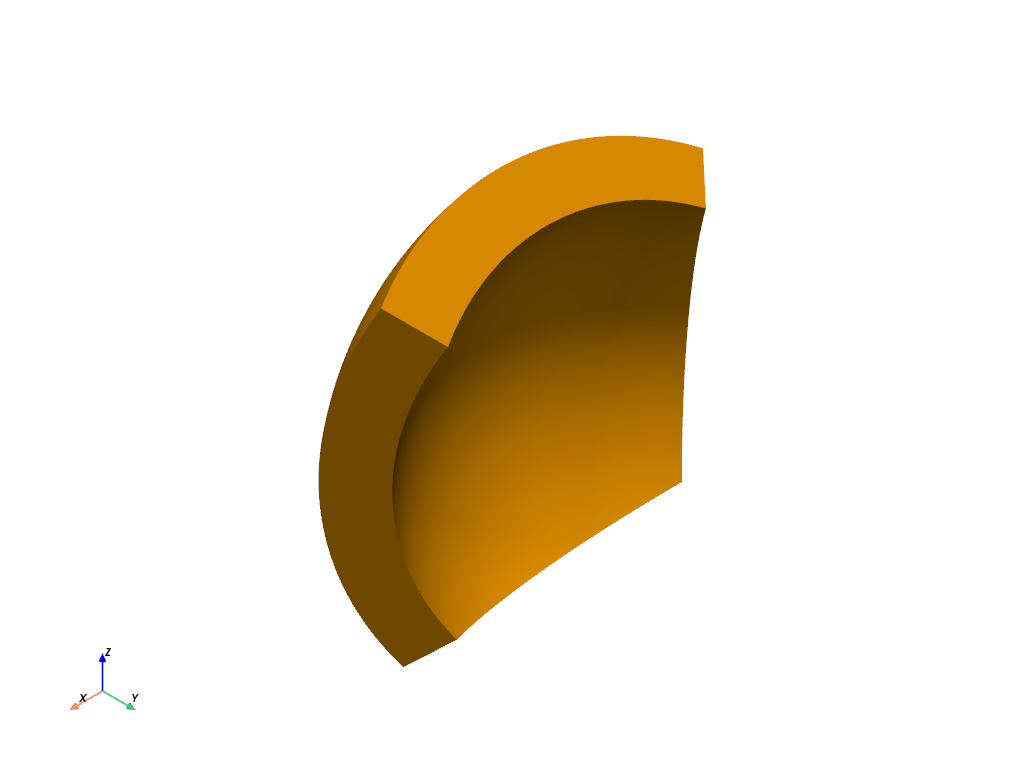

In [5]:
from geovista.geodesic import panel

americas_bbox = panel("americas")
americas_bbox.mesh.plot(color="orange")

Note that, the ``americas_bbox`` is constructed from **geodesic lines** i.e., great circles, and is a 3-D manifold i.e., a water-tight geometric structure. As such, we can then use it to extract points/cells from **any** underlying mesh. 

Before doing that, first let’s render the ``americas_bbox`` and the ``c48_sst`` mesh together so that we can see their relationship to one another and convince ourselves that the ``americas_bbox`` instance is indeed covering the correct panel of the cubed-sphere:

```{note}
---
class: margin, dropdown, toggle-shown
---
``plotter`` is a {py:class}`~geovista.geoplotter.GeoPlotter` instance. It inherits all the behaviour of a {py:class}`pyvista.Plotter` but also additional ✨ cartographic conveniences ✨ from {py:class}`~geovista.geoplotter.GeoPlotterBase`.
```

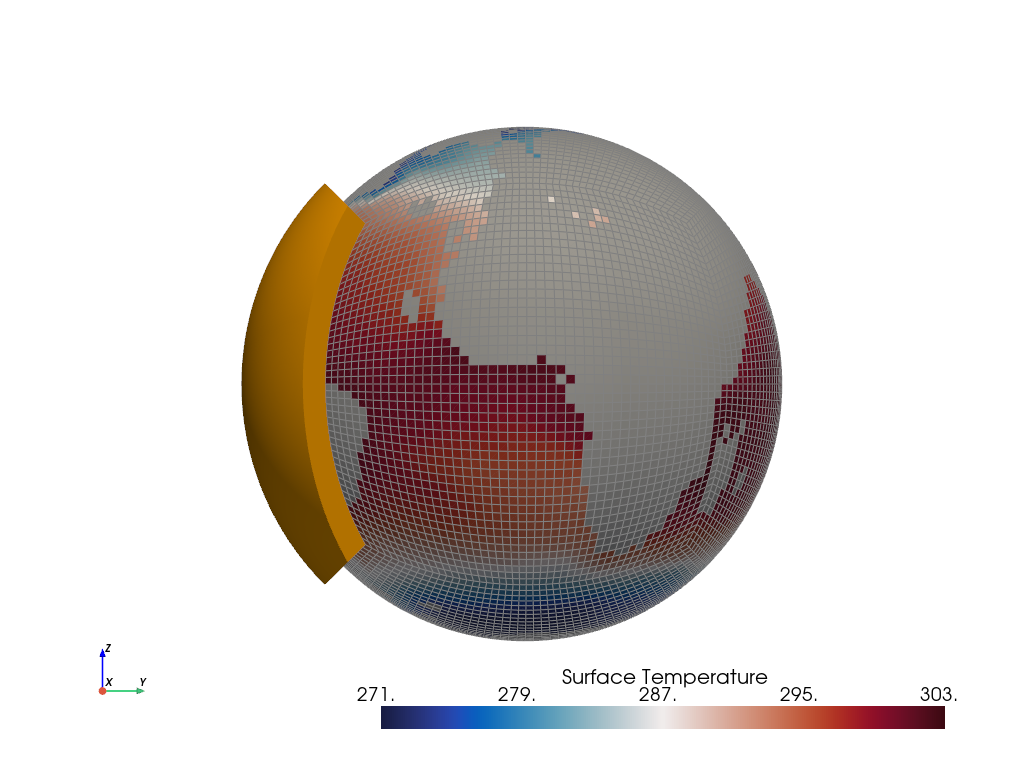

In [6]:
p = gv.GeoPlotter()

p.add_mesh(c48_sst, show_edges=True)
p.add_mesh(americas_bbox.mesh, color="orange")

p.view_yz()
p.camera.zoom(1.2)
p.add_axes()
p.show()

Seems to be right on the money! 👍

However, let's apply some ``opacity`` to the ``c48_sst`` mesh so that we can see through the surface and view the ``americas_bbox`` from a different angle.

We'll also use the {py:meth}`~geovista.geoplotter.GeoPlotterBase.view_poi` method to perform some cartographic camera controls on the rendered scene. Namey, move the camera to **30°E** longitude.

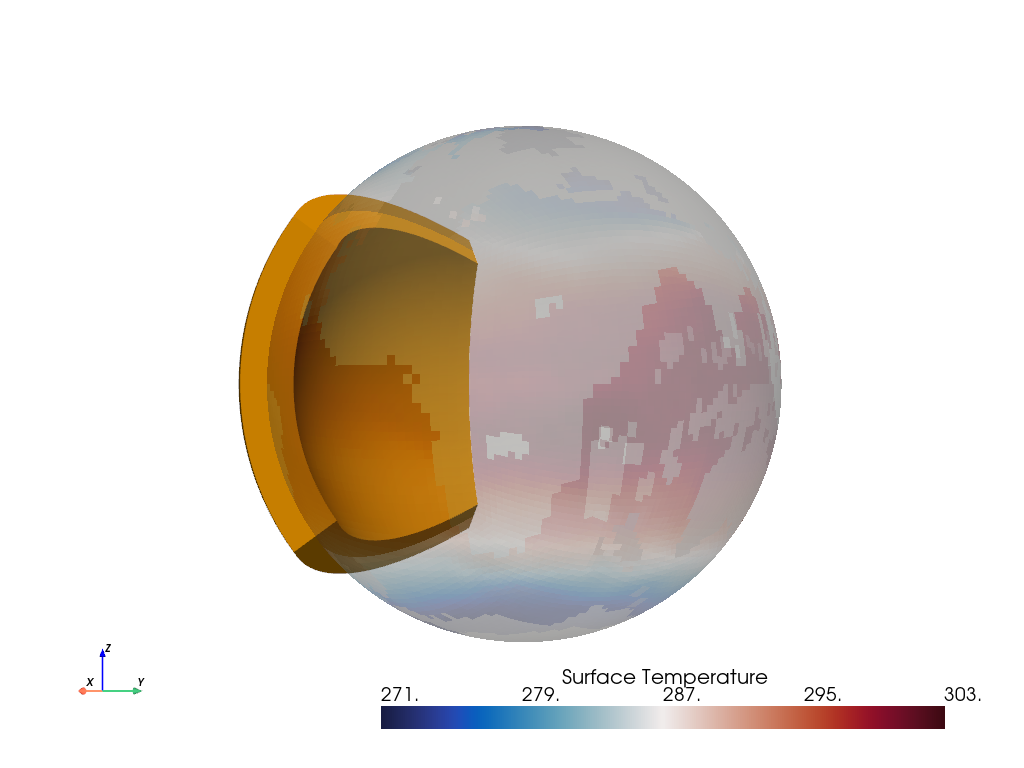

In [7]:
p = gv.GeoPlotter()
p.add_mesh(c48_sst, opacity=0.3)
p.add_mesh(americas_bbox.mesh, color="orange")

p.view_poi(x=30)

p.camera.zoom(1.2)
p.add_axes()
p.show()

Rather than viewing the entire bounding-box, sometimes it's more helpful to see only the boundary where the manifold intersects the surface of the mesh that it's enclosing.

We can achieve this by using the {py:meth}`geovista.geodesic.BBox.boundary` method:

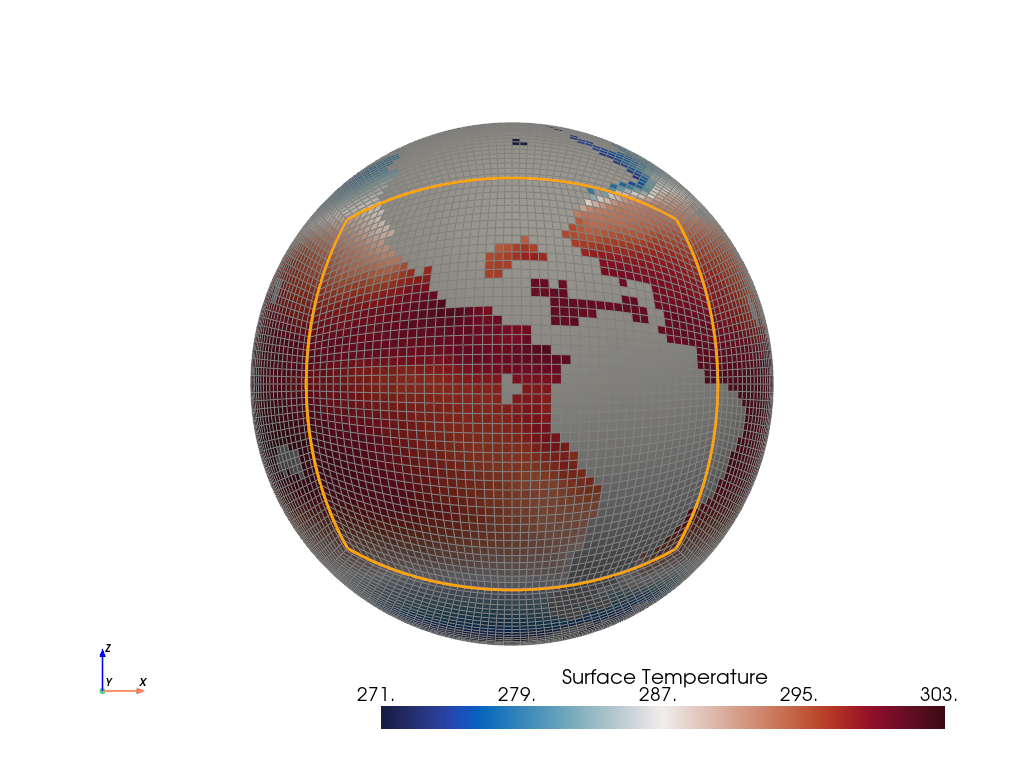

In [8]:
p = gv.GeoPlotter()
p.add_mesh(c48_sst, show_edges=True)

p.add_mesh(americas_bbox.boundary(), color="orange", line_width=5)

p.view_xz()
p.camera.zoom(1.2)
p.add_axes()
p.show()

Okay, so let's finally use the ``americas_bbox`` to extract cells from the ``c48_sst`` mesh by using the {py:meth}`geovista.geodesic.BBox.enclosed` method:

In [9]:
region = americas_bbox.enclosed(c48_sst)

The extracted ``region`` returned by {py:meth}`~geovista.geodesic.BBox.enclosed` is a {py:class}`pyvista.PolyData`. Under the hood {py:meth}`~geovista.geodesic.BBox.enclosed` uses the {py:meth}`pyvista.DataSetFilters.select_enclosed_points` method to achieve this. 

{fa}`flask` You may want to experiment with the ``preference`` *kwarg* of the {py:meth}`~geovista.geodesic.BBox.enclosed` method to see the impact on the end result.

Anyways, let's go ahead and see the extracted region, which should represent all the cells from the ``c48_sst`` mesh within the ``americas`` bounding-box:

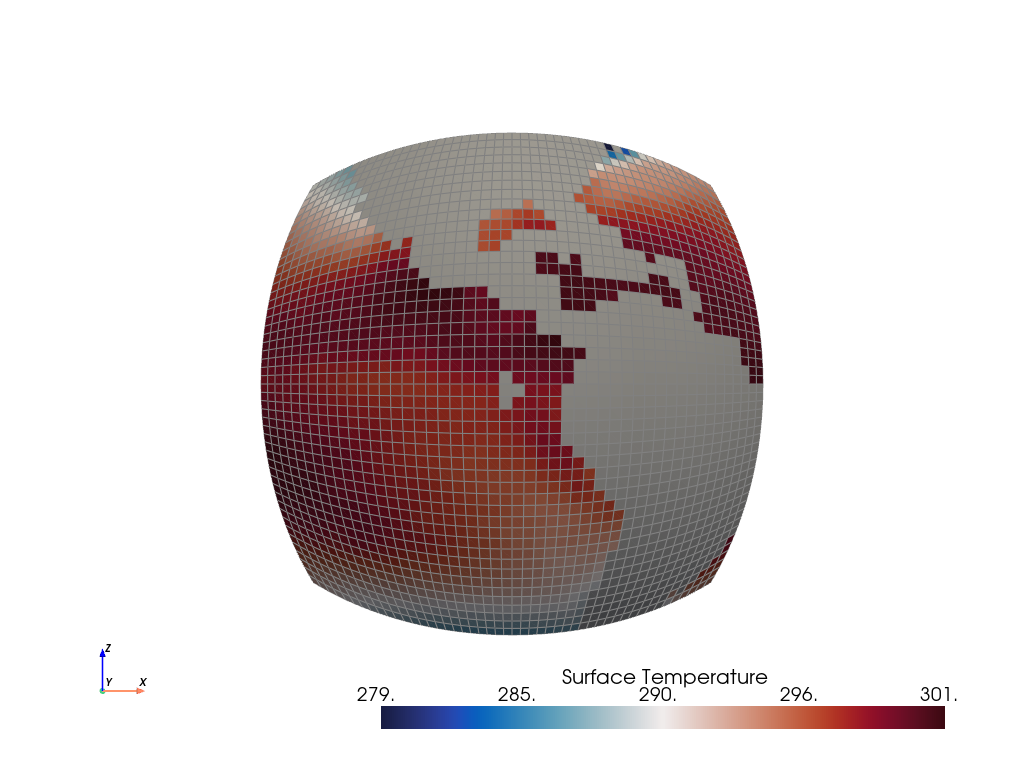

In [10]:
p = gv.GeoPlotter()

p.add_mesh(region, show_edges=True)

p.view_xz()
p.add_axes()
p.show()

```{hint}
---
class: margin, dropdown, toggle-shown
---
When you extract data from a mesh use the {py:meth}`pyvista.Plotter.add_mesh` ``clim`` *kwarg* to ensure the same colorbar range.
```

Now bring this all together by rendering the extracted region along with a [Natural Earth](https://www.naturalearthdata.com/) texture mapped base layer and coastlines:

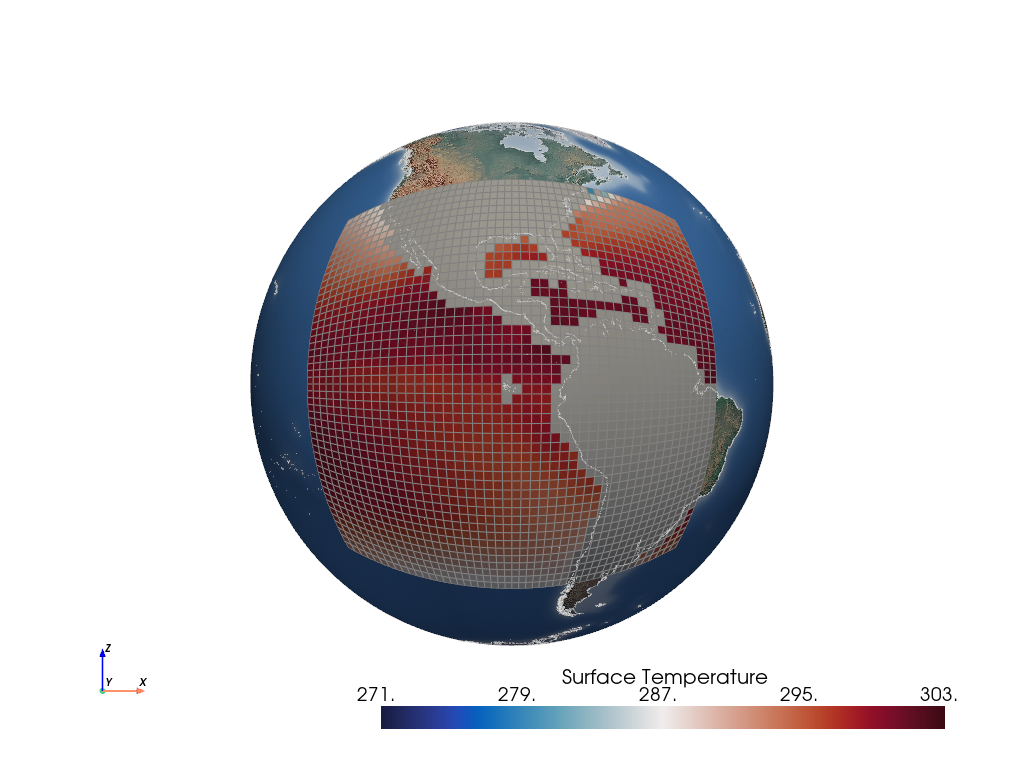

In [11]:
clim = (271, 303)

p = gv.GeoPlotter()
p.add_mesh(region, show_edges=True, clim=clim)

p.add_base_layer(texture=gv.natural_earth_hypsometric())
p.add_coastlines(resolution="10m")

p.view_xz()
p.camera.zoom(1.2)
p.show_axes()
p.show()

```{hint}
---
class: margin, dropdown, toggle-shown
---
Discover the data arrays available on a mesh with {py:attr}`pyvista.DataSet.array_names` and the active scalars with {py:attr}`pyvista.DataSet.active_scalars_name`.
```

As we're not particularly interested in the masked land masses, we can easily remove them using the {py:meth}`pyvista.DataSetFilters.threshold` method available on the ``region`` {py:class}`~pyvista.PolyData` instance.

By default, the {py:meth}`~pyvista.DataSetFilters.threshold` method will remove cells with ``nan`` values from the active scalars array on the mesh, which is just what we need:

In [12]:
sea_region = region.threshold()

Now let's respin the render, but with the ``sea_region`` mesh and add some S.I. units to the scalar bar:

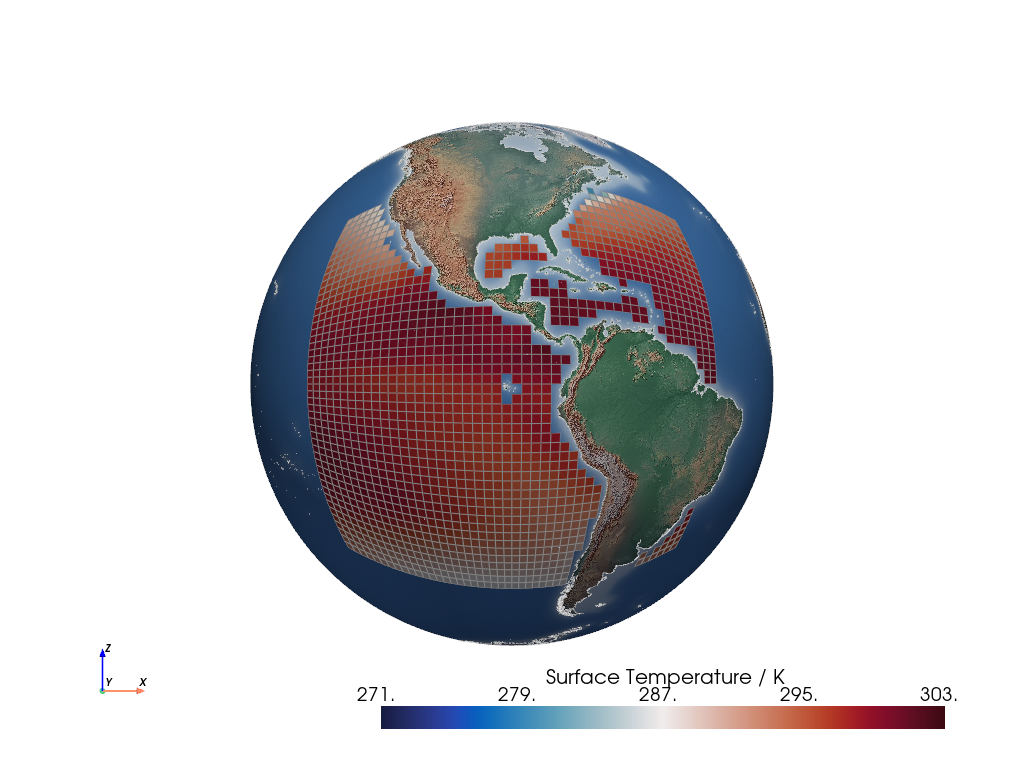

In [13]:
p = gv.GeoPlotter()

sargs = {"title": f"{sea_region.active_scalars_name} / K"}
p.add_mesh(sea_region, show_edges=True, clim=clim, scalar_bar_args=sargs)

p.add_base_layer(texture=gv.natural_earth_hypsometric())
p.add_coastlines(resolution="10m")
p.view_xz()
p.camera.zoom(1.2)
p.show_axes()
p.show()

### {fa}`user-astronaut` Extension

``geovista`` offers basic support for **Cylindrical** and **Pseudo-Cylindrical** cartographic projections. We're working on maturing this capability, and later extending to other classes of projections, such as **Azimuthal** and **Conic**.

To exercise this, let's transform our ``sea_region`` mesh to a [Robinson](https://proj.org/en/9.4/operations/projections/robin.html) projection using a [PROJ](https://proj.org/en/9.4/) string to define the Coordinate Reference System (CRS):

In [14]:
crs = "+proj=robin lon_0=-90"

```{note}
---
class: margin, dropdown, toggle-shown
---
If no ``crs`` is provided to {py:class}`~geovista.geoplotter.GeoPlotter`, it will assume geographic longitude and latitudes (``WGS84``), and render the mesh on a sphere.
```

We pass the ``crs`` as a *kwarg* to the {py:class}`~geovista.geoplotter.GeoPlotter` and render the projected scene:

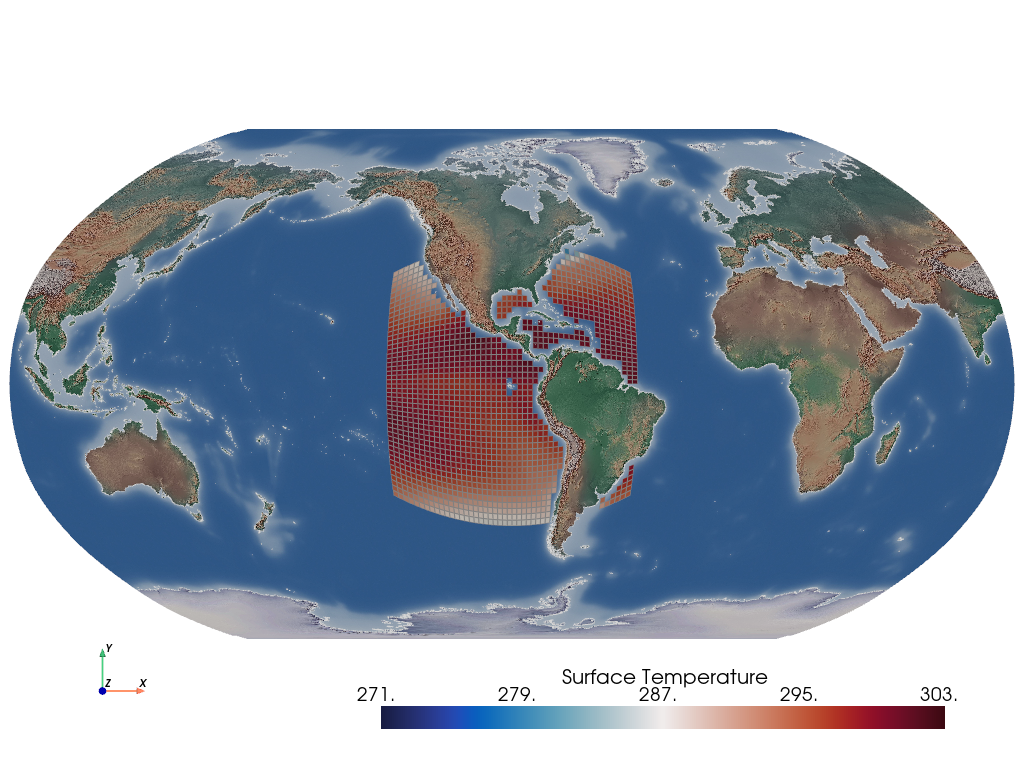

In [15]:
p = gv.GeoPlotter(crs=crs)
p.add_mesh(sea_region, show_edges=True, clim=clim)
p.add_base_layer(texture=gv.natural_earth_hypsometric())
p.add_coastlines(resolution="10m")
p.view_xy()
p.camera.zoom(1.5)
p.show_axes()
p.show()

Note that, the base layer and coastlines are also automatically transformed to the target projection.

``geovista`` also has an understanding of [cartopy](https://github.com/SciTools/cartopy) CRS's. So let's use ``cartopy`` to create a [Mollweide](https://proj.org/en/9.4/operations/projections/moll.html) CRS:

In [16]:
import cartopy.crs as ccrs

crs = ccrs.Mollweide(central_longitude=-90)

Before we use this CRS, let's **invert** the ``sea_region`` i.e., find all cells **not** enclosed by the ``americas_bbox`` manifold. We can easily do this using the ``outside`` *kwarg* of {py:meth}`~geovista.geodesic.BBox.enclosed`:

In [17]:
outside = americas_bbox.enclosed(c48_sst, outside=True)
sea_outside = outside.threshold()

Now let's see the final projected result:

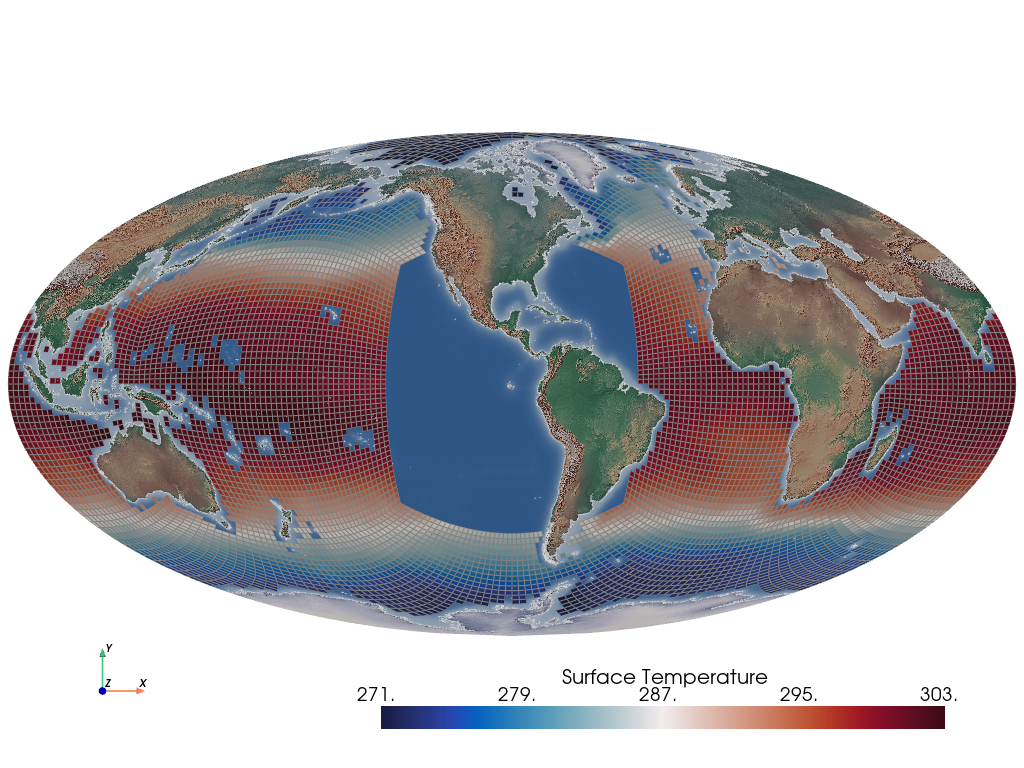

In [18]:
p = gv.GeoPlotter(crs=crs)
p.add_mesh(sea_outside, show_edges=True, clim=clim)
p.add_base_layer(texture=gv.natural_earth_hypsometric())
p.add_coastlines(resolution="10m")
p.view_xy()
p.camera.zoom(1.5)
p.show_axes()
p.show()

## {fab}`elementor` Summary

Key learning points of this tutorial:

- using the {py:mod}`geovista.pantry` to generate meshes
- creating a geodesic bounding-box manifold with {py:func}`~geovista.geodesic.panel`
- introduction to the {py:class}`~geovista.geodesic.BBox` class and using its {py:meth}`~geovista.geodesic.BBox.boundary`, {py:meth}`~geovista.geodesic.BBox.enclosed`, and {py:meth}`~geovista.geodesic.BBox.mesh` methods
- cartographic positioning of the camera with {py:meth}`~geovista.geoplotter.GeoPlotterBase.view_poi`
- performing a cell {py:meth}`~pyvista.DataSetFilters.threshold` of a mesh